In [944]:
import numpy as np
import torch 
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [945]:
device = torch.device('cpu')

In [946]:
#We follow Florian Marquardt (youtube) class about VAE. We will construct a VAE to induce a gaussian distribution on the latent space
# of an AutoEncoder that takes as inputs a set of random gaussian distributions. 

# We will start by constructing a simple AutoEncoder.

In [947]:
#Creating 1000 gaussian distribution with random means and variances  for training
# 100 for validation and 100 for test

y = [0]*1216
for i in range(1216):
    sigma = torch.from_numpy(np.random.uniform(low= 1, high=6, size=(1,),)).type(torch.float32)
    mu =  torch.from_numpy(np.random.uniform(low= -15, high=15, size=(1,))).type(torch.float32)
    x = torch.linspace(-20,20,400)
    y[i] = (1/torch.sqrt(torch.pi*2*sigma))*torch.exp(-(x-mu)**2/(2*sigma**2))

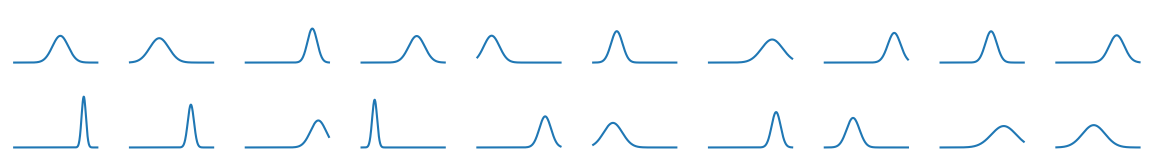

In [948]:
#Plotting first 20 gaussians

fig, ax = plt.subplots(2,10, sharex= True, sharey = True, figsize= (12,2))
fig.tight_layout()

a = -1
for j in range(2):
    for i in range(10):
        a += 1
        ax[j][i].plot(x,y[a])
        ax[j][i].axis('off')


In [949]:
#We use DataLoader to create a iterable with batches for training

bs = 64
ds = DataLoader(y[:960], batch_size = bs, shuffle= True)       #DataLoader for training 
val = DataLoader(y[960:1088], batch_size = bs, shuffle= True)  #for validation
test = DataLoader(y[1088:], batch_size = bs, shuffle= True)    #for test
len(ds), len(val), len(test)       

(15, 2, 2)

In [965]:
#Autoencoder 

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(400,100),
            nn.LeakyReLU(),
            nn.Linear(100,50),
            nn.LeakyReLU(),
            nn.Linear(50,10),
            nn.LeakyReLU(),
            nn.Linear(10,2),
            
        )

        self.decoder = nn.Sequential(
            nn.Linear(2,10),
            nn.LeakyReLU(),
            nn.Linear(10,50),
            nn.LeakyReLU(),
            nn.Linear(50,100),
            nn.LeakyReLU(),
            nn.Linear(100,400),

        )

        
    def forward(self,x):

        x = self.encoder(x)
        x = self.decoder(x)

        return x
    

In [966]:
model = Autoencoder()
model.to(device)
model.train()
parameter_size = sum((p.numel() for p in model.parameters()))
print(model, f'Number of parameters = {parameter_size}')


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=400, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=10, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=50, out_features=100, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=100, out_features=400, bias=True)
  )
) Number of parameters = 91762


In [967]:
#Loss and Optim

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(params = model.parameters(), lr = 0.01)

In [968]:
# Training Loop

epochs = 120

def training(model):

    hist_train = []

    hist_val = []

    for i in tqdm(range(epochs)):


        total_loss_train = 0
       
        #Training loop
       
        for batch in ds:

            model.train()

            batch = batch.to(device)

            output = model(batch)

            loss = loss_fn(output,batch)

            optim.zero_grad()
            loss.backward()
            optim.step()

            total_loss_train += loss.item()
            hist_train = np.append(hist_train,loss.item())


            #Validation loop
        
            with torch.no_grad():

                for batch in val:

                    model.eval()

                    total_loss_val = 0

                    output = model(batch)

                    loss = loss_fn(output, batch)

                    total_loss_val += loss.item()

                hist_val = np.append(hist_val,loss.item())


        if i % 10 == 0:

            print(f'Epoch({i+1}/{epochs}) : Total loss = {total_loss_train:.5f} : Validation Loss{total_loss_val: .5f}')

    return hist_train, hist_val


In [969]:
hist = training(model)

  2%|▏         | 2/120 [00:00<00:14,  8.26it/s]

Epoch(1/120) : Total loss = 0.08323 : Validation Loss 0.00392


 11%|█         | 13/120 [00:01<00:09, 10.93it/s]

Epoch(11/120) : Total loss = 0.00756 : Validation Loss 0.00043


 19%|█▉        | 23/120 [00:02<00:09, 10.72it/s]

Epoch(21/120) : Total loss = 0.00338 : Validation Loss 0.00024


 28%|██▊       | 33/120 [00:03<00:08, 10.64it/s]

Epoch(31/120) : Total loss = 0.00234 : Validation Loss 0.00015


 36%|███▌      | 43/120 [00:04<00:07, 10.71it/s]

Epoch(41/120) : Total loss = 0.00170 : Validation Loss 0.00015


 44%|████▍     | 53/120 [00:05<00:06, 10.92it/s]

Epoch(51/120) : Total loss = 0.00149 : Validation Loss 0.00012


 51%|█████     | 61/120 [00:05<00:05, 10.69it/s]

Epoch(61/120) : Total loss = 0.00142 : Validation Loss 0.00008


 60%|██████    | 72/120 [00:06<00:05,  9.35it/s]

Epoch(71/120) : Total loss = 0.00119 : Validation Loss 0.00009


 68%|██████▊   | 82/120 [00:07<00:03,  9.85it/s]

Epoch(81/120) : Total loss = 0.00094 : Validation Loss 0.00006


 77%|███████▋  | 92/120 [00:08<00:02, 10.61it/s]

Epoch(91/120) : Total loss = 0.00090 : Validation Loss 0.00006


 85%|████████▌ | 102/120 [00:09<00:01, 10.21it/s]

Epoch(101/120) : Total loss = 0.00083 : Validation Loss 0.00005


 92%|█████████▎| 111/120 [00:10<00:00, 10.70it/s]

Epoch(111/120) : Total loss = 0.00067 : Validation Loss 0.00005


100%|██████████| 120/120 [00:11<00:00, 10.19it/s]


Text(0.5, 1.0, 'Loss x Validation Loss')

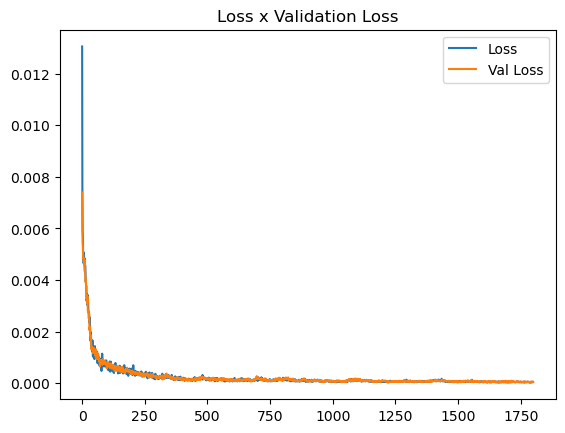

In [970]:
plt.plot(hist[0])
plt.plot(hist[1])
plt.legend(['Loss','Val Loss'])
plt.title('Loss x Validation Loss')

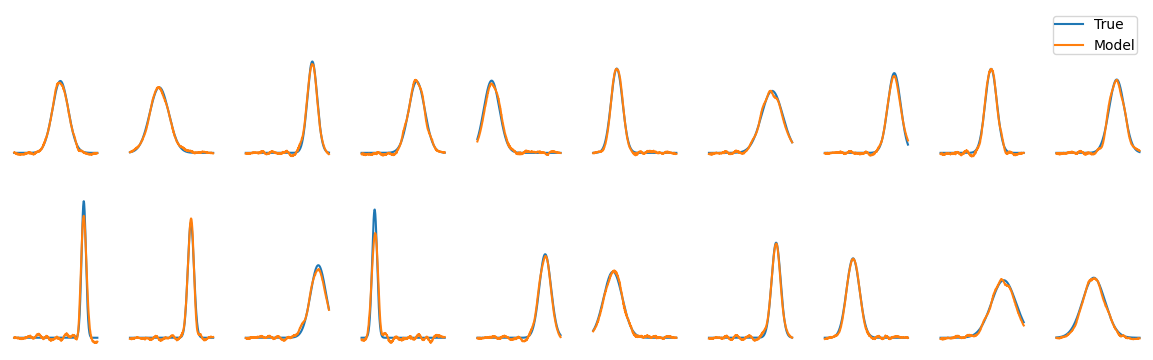

In [971]:
with torch.no_grad():
    
    fig, ax = plt.subplots(2,10, sharex= True, sharey = True, figsize= (12,4))
    fig.tight_layout()


    a = -1


    for i in range(10):

        a +=1

        ax[0][i].plot(x,y[a], label = 'True')
        ax[0][i].axis('off')
        ax[0][i].plot(x,model(y[a]).data, label = 'Model')
        ax[0][9].legend(['True','Model'], borderpad=0.1)
        ax[1][i].plot(x,y[a+10])
        ax[1][i].axis('off')
        ax[1][i].plot(x,model(y[a+10]).data)
        


In [972]:
# Latent Space ?

#With this loop we will get the latent space coordinates for each gaussian, and it´s center location, and amplitude.

with torch.no_grad():

    latentx = []
    latenty = []
    loc = []
    amplitude = []

    for batch in ds:

        for dist in batch:

            a, l = torch.max(dist,0)

            amplitude = np.append(amplitude, a)     #Amplitude

            loc = np.append(loc, x[l])              #Center

            lx,ly  = model.encoder(dist)

            latentx = np.append(latentx, lx)

            latenty = np.append(latenty, ly)


Text(0.5, 1.0, 'Center Location')

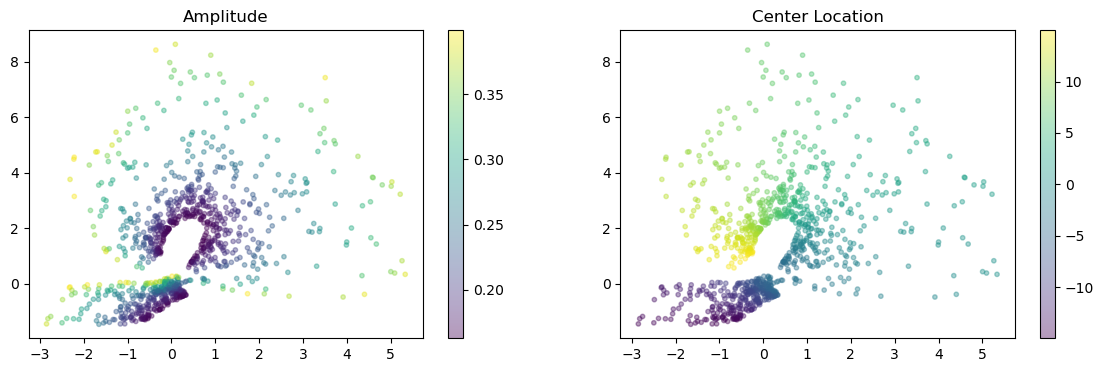

In [973]:
#Plotting latent space labeled for amplitudes and center location.

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(1, 2, 1)
plt.scatter(latentx,latenty, c=amplitude, s=10, alpha=0.4)
plt.colorbar()
plt.title('Amplitude')
fig.add_subplot(1, 2, 2)
plt.scatter(latentx,latenty, c=loc, s=10, alpha=0.4)
plt.colorbar()
plt.title('Center Location')


In [ ]:
#And what happens if we choose random (normal) point on the latent space ?

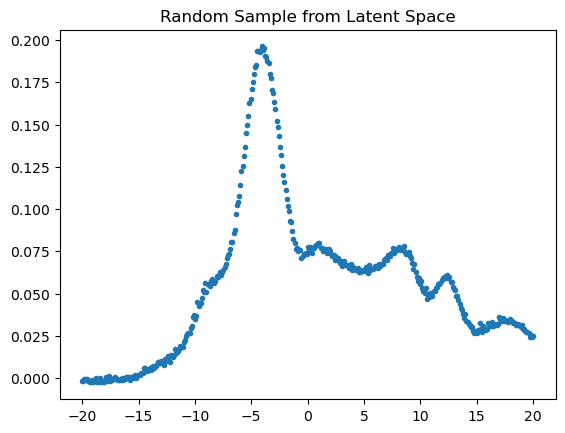

In [974]:
with torch.no_grad():
    u = torch.rand((2,))
    u = model.decoder(u)
    plt.plot(x,u,'.')
    plt.title('Random Sample from Latent Space')

In [62]:
#Now we will construct a VAE, to induce a gaussian distribution for the latent space.

# Review:

An AutoEncoder (A = d(e(x))) is a deterministic function, that takes an input x, and maps to the latent space z = e(x), 
and then later maps z to an output x' = d(z). 

The idea of an VAE is to exchange z, and x' to probability distributions. (${\theta} = $ model parameters)

z = $g_{\theta}$(x,$\epsilon$) : $\epsilon$ = noise  ---> z $\approx$ $q_{\theta}(z|x)$ (probability distribution), where

g(x,$\epsilon$) = $g^{\mu} + g^{\sigma}\odot \epsilon$ : $\odot$ is a element-wise multiplication. (mean + variance*normal)

And

x' = $f_{\theta}$(z,$\zeta$) :   $\zeta$ = noise ---> x' $\approx$ $p_{\theta}$(x'|z) (probability distribution), where

$f_{\theta}$(z,$\zeta$) = $f_{\theta}$(z) + $\zeta$  (mean + normal)

The idea is that our inputs have already some probabilistic distribution P(x). We want our model distribution to be as closer to this one, that
means we want to minimize the KL-divergence $D_{LK}(P(x)||p_{\theta}(x))$ (= maximize expectation $<log(p_{\theta}(x))>_{P(x)}$ under the true probability P(x)), but under a certain constraint distribution in the latent space (p(z) (gaussian)).

If we compute this KL-divergence, and use our precious assumptions, we can get (see online lecture) that we have to maximize

$L = L_1 + \alpha L_2$, where $\alpha$ is just a hyperparameter of coupling

$L_1 = const + - \frac{1}{2}||x - f_{\theta}(z)||^2$), which is the MSE of a normal autoencoder

$L_2 = -\frac{1}{2}\sum_{j \in latent space}( 1 + log(\sigma_j^2(x)) - \mu^2_j(x) - \sigma^2_j(x)))$, which is a new loss that will tries make the latent space have our constrained distribution







In [112]:
#Now for the implementation 

In [932]:
#VAE 

Ldim = 2                                        #We leave the latent dimension a variable

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(400,200),
            nn.Tanh(),
            nn.Linear(200,100),
            nn.Tanh(),
            nn.Linear(100,50),
            nn.Tanh(),
            nn.Linear(50,25),
            

        )

        self.mu = nn.Linear(25,Ldim)                 #We going to learn our distribution parameters

        self.logsigma =  nn.Linear(25,Ldim)          #We use log sigma bc it can give negative and positive values, while sigma have to be positive (easier to train)


        self.decoder = nn.Sequential(
            nn.Linear(Ldim,10),
            nn.Tanh(),
            nn.Linear(10,25),
            nn.Tanh(),
            nn.Linear(25,50),
            nn.Tanh(),
            nn.Linear(50,100),
            nn.Tanh(),
            nn.Linear(100,200),
            nn.Tanh(),
            nn.Linear(200,400)
        )

        
    def forward(self,x):

        x = self.encoder(x)

        z_mu, z_logsigma = self.mu(x), self.logsigma(x)
        eps = torch.randn(z_mu.size(0), z_mu.size(-1))                      #our episilon
        z = z_mu + eps * torch.exp(z_logsigma/2.)          

        x = self.decoder(z)
        

        return x, z, z_mu, z_logsigma
    

In [933]:
VAEmodel = VAE()
VAEmodel.to(device)
VAEmodel.train()
parameter_size = sum((p.numel() for p in VAEmodel.parameters()))
print(VAEmodel, f'Number of parameters = {parameter_size}')

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=25, bias=True)
  )
  (mu): Linear(in_features=25, out_features=2, bias=True)
  (logsigma): Linear(in_features=25, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=25, bias=True)
    (3): Tanh()
    (4): Linear(in_features=25, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=200, bias=True)
    (9): Tanh()
    (10): Linear(in_features=200, out_features=400, bias=True)
  )
) Number of parameters = 214034


In [938]:
optim = torch.optim.Adam(params = VAEmodel.parameters(), lr = 0.0001)

In [935]:
# Training Loop

#lr and coupling constant needs a lot of fine tunning

epochs = 200

def trainingVAE(VAE):

    hist_train = []
    hist_KL = []
    hist_val = []



    for i in tqdm(range(epochs)):


        total_loss_train = 0
        lossKL = 0
       
        #Training loop
       
        for batch in ds:

            VAEmodel.train()

            batch = batch.to(device)

            x, z, z_mu, z_log_var = VAEmodel(batch)

            KLoss =  -0.5*torch.sum(1 + z_log_var - torch.square(z_mu) - torch.exp(z_log_var), axis= -1) #sum of latent space
            KLoss = KLoss.mean()
            loss= F.mse_loss(x,batch) + 0.0005*KLoss
            
            optim.zero_grad()
            loss.backward()
            optim.step()

            total_loss_train += loss.item()

            hist_train = np.append(hist_train,loss.item())
            hist_KL = np.append(hist_KL,KLoss.item())

            #Validation loop
        
            # with torch.no_grad():

            #     for batch in val:

            #         VAEmodel.eval()

            #         total_loss_val = 0

            #         x, z, z_mu, z_log_var = VAEmodel(batch)

            #         loss= F.mse_loss(x,batch) + 0.0003*KLoss

            #         total_loss_val += loss.item()

            #     hist_val = np.append(hist_val,loss.item())

        if i % 10 == 0:

            print(f'Epoch({i+1}/{epochs}) : Total loss = {total_loss_train:.5f} : Validation Loss{0: .5f}')

    return hist_train, hist_KL, hist_val

In [939]:
hist = trainingVAE(VAE)

  1%|          | 2/200 [00:00<00:25,  7.82it/s]

Epoch(1/200) : Total loss = 0.02949 : Validation Loss 0.00000


  6%|▋         | 13/200 [00:01<00:19,  9.50it/s]

Epoch(11/200) : Total loss = 0.02974 : Validation Loss 0.00000


 11%|█         | 22/200 [00:02<00:18,  9.56it/s]

Epoch(21/200) : Total loss = 0.02932 : Validation Loss 0.00000


 16%|█▌        | 32/200 [00:03<00:15, 10.63it/s]

Epoch(31/200) : Total loss = 0.02884 : Validation Loss 0.00000


 22%|██▏       | 43/200 [00:04<00:15,  9.82it/s]

Epoch(41/200) : Total loss = 0.02924 : Validation Loss 0.00000


 26%|██▋       | 53/200 [00:05<00:14,  9.92it/s]

Epoch(51/200) : Total loss = 0.02899 : Validation Loss 0.00000


 31%|███       | 62/200 [00:06<00:14,  9.56it/s]

Epoch(61/200) : Total loss = 0.02889 : Validation Loss 0.00000


 36%|███▌      | 72/200 [00:07<00:16,  7.98it/s]

Epoch(71/200) : Total loss = 0.02902 : Validation Loss 0.00000


 41%|████      | 82/200 [00:08<00:13,  8.50it/s]

Epoch(81/200) : Total loss = 0.02947 : Validation Loss 0.00000


 46%|████▌     | 92/200 [00:10<00:12,  8.42it/s]

Epoch(91/200) : Total loss = 0.02913 : Validation Loss 0.00000


 51%|█████     | 102/200 [00:11<00:12,  7.98it/s]

Epoch(101/200) : Total loss = 0.02895 : Validation Loss 0.00000


 56%|█████▌    | 112/200 [00:12<00:10,  8.78it/s]

Epoch(111/200) : Total loss = 0.02893 : Validation Loss 0.00000


 61%|██████    | 122/200 [00:13<00:08,  8.70it/s]

Epoch(121/200) : Total loss = 0.02953 : Validation Loss 0.00000


 66%|██████▌   | 132/200 [00:14<00:07,  9.04it/s]

Epoch(131/200) : Total loss = 0.02932 : Validation Loss 0.00000


 71%|███████   | 142/200 [00:15<00:06,  9.32it/s]

Epoch(141/200) : Total loss = 0.02976 : Validation Loss 0.00000


 76%|███████▌  | 152/200 [00:16<00:05,  8.49it/s]

Epoch(151/200) : Total loss = 0.02934 : Validation Loss 0.00000


 81%|████████  | 162/200 [00:17<00:04,  8.38it/s]

Epoch(161/200) : Total loss = 0.02913 : Validation Loss 0.00000


 86%|████████▌ | 172/200 [00:18<00:03,  8.23it/s]

Epoch(171/200) : Total loss = 0.02908 : Validation Loss 0.00000


 91%|█████████ | 182/200 [00:20<00:02,  7.94it/s]

Epoch(181/200) : Total loss = 0.02887 : Validation Loss 0.00000


 96%|█████████▌| 192/200 [00:21<00:00,  8.40it/s]

Epoch(191/200) : Total loss = 0.02966 : Validation Loss 0.00000


100%|██████████| 200/200 [00:22<00:00,  8.96it/s]


Text(0.5, 1.0, 'KL Loss')

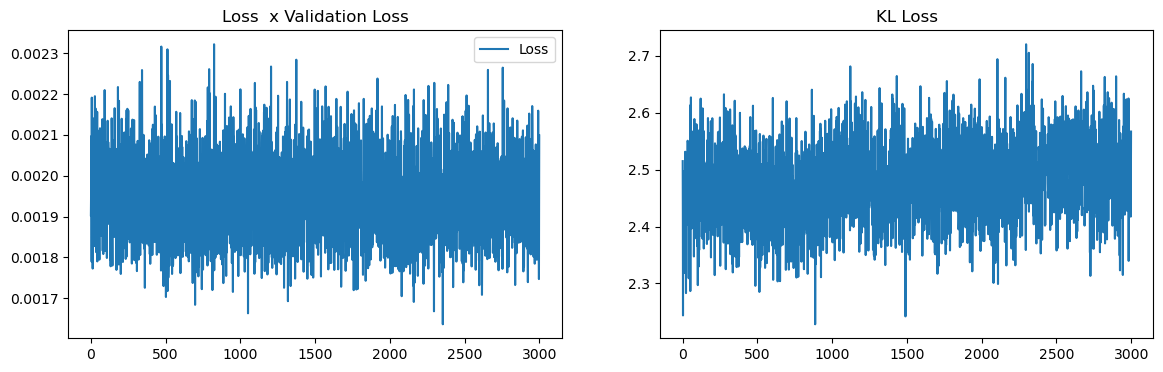

In [940]:
fig = plt.figure(figsize=(14, 4))
fig.add_subplot(1,2,1)
plt.plot(hist[0])
# plt.plot(hist[2])
plt.legend(['Loss','Val Loss'])
plt.title('Loss  x Validation Loss')
fig.add_subplot(1,2,2)
plt.plot(hist[1])
plt.title('KL Loss')



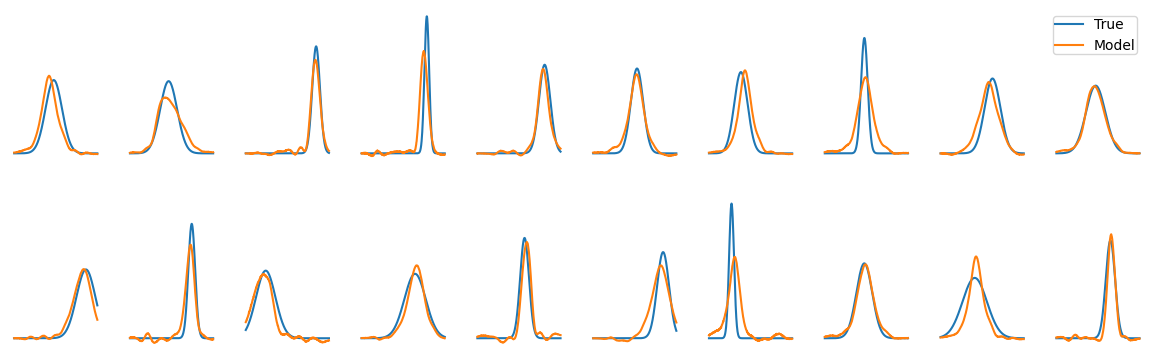

In [941]:
with torch.no_grad():
    
    fig, ax = plt.subplots(2,10, sharex= True, sharey = True, figsize= (12,4))
    fig.tight_layout()


    a = -1


    for i in range(10):

        a +=1

        ax[0][i].plot(x,y[a], label = 'True')
        ax[0][i].axis('off')
        ax[0][i].plot(x,VAEmodel(y[a][None,:])[0][0].data, label = 'Model')
        ax[0][9].legend(['True','Model'], borderpad=0.1)
        ax[1][i].plot(x,y[a+10])
        ax[1][i].axis('off')
        ax[1][i].plot(x,VAEmodel(y[a+10][None,:])[0][0].data)

In [986]:
# Latent Space ?

#With this loop we will get the latent space coordinates for each gaussian, and it´s center location, and amplitude.

with torch.no_grad():

    latentx = []
    latenty = []
    loc = []
    amplitude = []

    for batch in ds:

        for dist in batch:

            a, l = torch.max(dist,0)

            amplitude = np.append(amplitude, a)     #Amplitude

            loc = np.append(loc, x[l])              #Center

            z = VAEmodel(dist[None,:])[1]

            latentx = np.append(latentx, z[0][0])

            latenty = np.append(latenty, z[0][1])


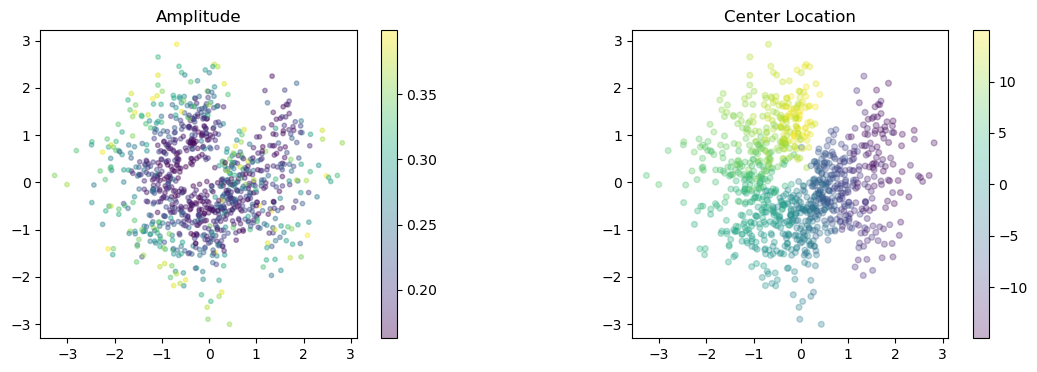

In [1023]:
#Plotting latent space labeled for amplitudes and center location.

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(1, 2, 1)
plt.scatter(latentx,latenty,c=amplitude, s=10, alpha=0.4)
plt.colorbar()
plt.title('Amplitude')
ax = plt.gca()
ax.set_aspect(1)
fig.add_subplot(1, 2, 2)
plt.scatter(latentx,latenty, c=loc, s=17, alpha=0.3)
plt.colorbar()
plt.title('Center Location')
ax = plt.gca()
ax.set_aspect(1)

In [ ]:
#We observe that the model decided to associate the x coordinate (of latent space) to a angle coordinate,
#and some kind of radial coordinate for the amplitude.

In [ ]:
#For the sake of Machine Learning (we could do this extracting it directly from the model), we will compute the variation of the gaussian
#using SVD


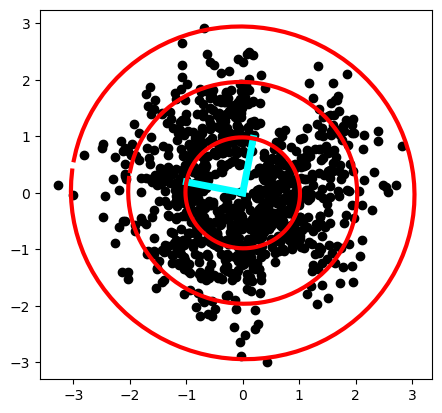

In [1057]:
A = np.vstack((latentx,latenty))
A = A 
U,S,VT = np.linalg.svd(A/np.sqrt(960),full_matrices=True)                      #I'm assuming the center at (0,0.. it seens close to it)

theta = 2 * np.pi * np.arange(0,1,0.01)
# 1-std confidence interval
Astd = U @ np.diag(S) @ np.array([np.cos(theta),np.sin(theta)])

plt.scatter(*A, color='k')
plt.plot(np.array([0,U[0,0]*S[0]]),
         np.array([0,U[0,1]*S[0]]),'-',color='cyan',linewidth=5)
plt.plot(np.array([0,U[0,1]*S[1]]),
         np.array([0,U[1,1]*S[1]]),'-',color='cyan',linewidth=5)

plt.plot(Astd[0,:],  Astd[1,:],'-',color='r',linewidth=3)
plt.plot(2*Astd[0,:], 2*Astd[1,:],'-',color='r',linewidth=3)
plt.plot(3*Astd[0,:], 3*Astd[1,:],'-',color='r',linewidth=3)
ax = plt.gca()
ax.set_aspect(1)

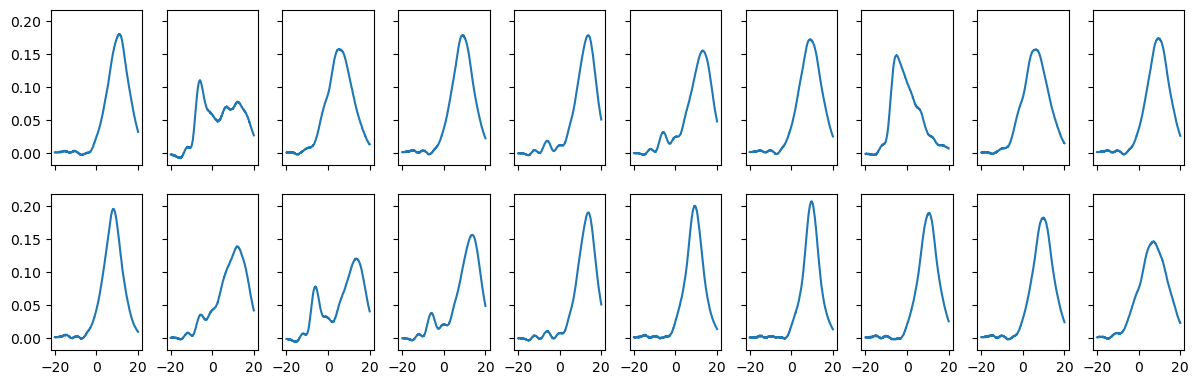

In [1082]:
with torch.no_grad():
    
    fig, ax = plt.subplots(2,10, sharex= True, sharey = True, figsize= (12,4))
    fig.tight_layout()

with torch.no_grad():
    for i in range(10):
        u1 = torch.Tensor(U)@torch.diag(torch.Tensor(S))@torch.rand((2,1))
        u1 = VAEmodel.decoder(u1.T)[0]
        u2 = torch.Tensor(U) @ torch.diag(torch.Tensor(S))@torch.rand((2,1))
        u2 = VAEmodel.decoder(u2.T)[0]
        x = torch.linspace(-20,20,400)
        ax[0][i].plot(x,u1.T)
        ax[1][i].plot(x,u2.T)
